### Cena 1
- Simulação com a mini câmara sem material.
- Aplicando impedância de superfície calculada apartir da formulação da ISO 354.


### Importando bibliotecas


In [2]:
# Importando bibliotecas

import femder as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from femder.FEM_3D import  p2SPL

UnboundLocalError: local variable 'MKLlib' referenced before assignment

### Importando resultados experimentais
- velocidade de volume
- coef. absorção ISO 354
- sinal medido nos receptores
- respostas impulsivas

In [41]:
import scipy.io as sio

q = sio.loadmat(r'G:\\Meu Drive\\TCC\\Simulacao_computacional\\Qi.mat')
# sorted(q.keys())
q = q['Qi']

as_medido = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\sem_material\\as_vazia.mat')
# sorted(as_medido.keys())

R_semMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\Medicao_tcc2\\Dados_medicao\\R_semMatfreq.mat')
# sorted(R_semMat.keys())

RI_semMat = sio.loadmat(r'G:\\Meu Drive\\TCC\\Experimental\\sem_material\\RIs.mat')



### Importar geometria, inicializando as classes dos dados de entrada da simulação

In [176]:
# Importar geometria, inicializando as classes dos dados de entrada da simulação

path_to_geo = "G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\minicamara_menor\minicamara_volmenor.iges"

AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2300
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,0.5)
#AC = fd.AlgControls(AP,fmin,fmax,1)
S = fd.Source("spherical")
S.coord = np.array([[1.222,0.15,0.2]])
#S.q = np.array(q[0,:1700]) #até 500 Hz
S.q = np.array(q) 
R = fd.Receiver()
#R.coord = np.array([[0.33,0.23,0.21],[0.38,0.93,0.21],[0.92,0.95,0.21]]) 
R.coord = np.array([[1.057,0.695,0.282],[0.425,0.925,0.235],
                    [0.409,0.406,0.235],[0.336,0.677,0.282],
                    [0.685,0.965,0.235],[0.661,0.30,0.235]])
 

In [101]:
AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2300
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,0.5)
np.argwhere(AC.freq==1000)

array([[1700]], dtype=int64)

In [70]:
# Recuperando a impedância de superficie das paredes da minicamara apartir do coef. de abs medido pela ISO 354

from sea.sea.materials import Material as mat

#with open(r"G:\Meu Drive\TCC\codes\dados-pickle\admitance_minicamara1.pkl","rb") as arquivo:
  #sup_admittance = pickle.load(arquivo)
  
#sup = mat(octave_bands_statistical_alpha = [0.0323, 0.0279, 0.0266, 0.0365, 0.0366], octave_bands = [250, 500, 1000, 2000, 4000], freq_vec=AC.freq)
sup = mat(third_octave_bands_statistical_alpha=[0.0332, 0.0351, 0.0325, 0.037, 0.045, 0.048, 0.056, 0.06, 0.065, 0.068, 0.07], third_octave_bands = [200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000], freq_vec=AC.freq)
sup.impedance_from_alpha(absorber_type="hard")
sup_admittance = sup.admittance # Admitancia normalizada
sup_surface_impedance = sup.surface_impedance # Impedancia não normalizada 

Working on the solution of the constrained optimization problem...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02331924593398403
            Iterations: 22
            Function evaluations: 132
            Gradient evaluations: 22
[ 1.89128440e-18  9.99802528e-01  8.38133234e+01  1.97865584e-05
 -2.09865967e-04]
The solution of the optimization problem leads to rmk+1 parameters equal to [ 1.89128440e-18  9.99802528e-01  8.38133234e+01  1.97865584e-05
 -2.09880868e-04].
Impedances, admittances and everything else related to it was already calculated.



In [3]:
# with open('G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\sup_admittance150-2K.pkl', "wb") as arquivo:
#     pickle.dump(sup, arquivo)

# import pickle
with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\sup_admittance150-2K.pkl","rb") as arquivo:
  sup = pickle.load(arquivo)

In [177]:
# Boundary Conditions
BC = fd.BC(AC,AP) #[2,3,4,5,6,7]
BC.normalized_admittance(list(np.arange(2,8,1)),0.004)#sup.admittance)

### Verificação da equivalência entre os alphas (in x recuperado)

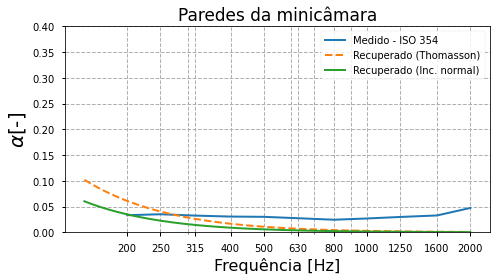

In [72]:
# Verificação da equivalência entre os coefs 
## () analisar recuperando com alphas em bando de terç de oitava
## () calcular erro entre os coefs
z_ar = AP.c0*AP.rho0
Zs = sup.surface_impedance/z_ar
Reflexao = (Zs - 1) / (Zs + 1)
Absorcao = 1 - (np.abs(Reflexao) ** 2)  # 1 - |R|²
plt.figure(figsize=(7,4))
plt.semilogx(as_medido['f'][:11], as_medido['a_s'][:11], linestyle='-', label = 'Medido - ISO 354',linewidth=2)
plt.semilogx(AC.freq, sup.statistical_alpha,label='Recuperado (Thomasson)', linestyle='--', linewidth=2)
plt.semilogx(AC.freq, Absorcao, linestyle='-', label = 'Recuperado (Inc. normal)',linewidth=2)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.title('Paredes da minicâmara', fontsize=17)
plt.xlabel('Frequência [Hz]', fontsize=16)
plt.ylabel(r'$\alpha$[-]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
plt.tight_layout()
plt.ylim((0,0.4))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
plt.show()

### Geração da malha, inicializando a classe FEM3D com os dados de entrada e o plote da geomeria com a malha 2D


In [178]:
grid = fd.GridImport3D(AP,path_to_geo,S,R,fmax = fmax,num_freq=6,scale=1000,order=1,load_method='meshio')
obj = fd.FEM3D(grid,S,R,AP,AC,BC)
obj.plot_problem(renderer='browser',saveFig=False,camera_angles=['diagonal_front'],extension='png')

### Cálculo das pressões com o método de elementos finitos

In [179]:
obj.compute() # debug e comparar vel const e dpendente freqa
obj.evaluate(R)

FEM | Assembling surface matrix: 100%|█████████████████████████| 6/6 [00:00<00:00, 35.32it/s]
100%|██████████| 3701/3701 [2:44:45<00:00,  2.67s/it]  


Time taken: 164.93187950452167 min


array([[-0.00488476+1.10876029j, -0.0629924 -1.30964159j,
        -0.06048775-1.47203742j, -0.05987554-1.57714839j,
        -0.03780686-0.43864139j, -0.04622303-0.33594414j],
       [ 0.00733078+1.03272108j, -0.0766204 -1.25860484j,
        -0.07899633-1.40858628j, -0.07801549-1.50681673j,
        -0.04148421-0.43086501j, -0.05218937-0.34017949j],
       [ 0.0171278 +0.96391743j, -0.08871097-1.2130581j ,
        -0.09539454-1.35345192j, -0.0939155 -1.44462441j,
        -0.04502883-0.42383351j, -0.05814875-0.34595802j],
       ...,
       [-0.32887044+0.37239714j, -0.32101745-0.01145093j,
         0.36016603-0.41481249j,  0.25689033-0.24310783j,
        -0.25645331+0.00280036j, -0.05738337+0.42549808j],
       [-0.18437521+0.40570716j, -0.26659144+0.06119337j,
         0.2944789 -0.47064613j,  0.18087374-0.25128846j,
        -0.22974216+0.05145239j, -0.02712796+0.3818902j ],
       [-0.04805467+0.36082411j, -0.17992404+0.101539j  ,
         0.21584386-0.50166875j,  0.13260823-0.22703775

In [161]:
# Salva var
with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_semMat\\Zs_0_004_obj_Minicamara1_150_2000_0_5.pkl", "wb") as arquivo:
    pickle.dump(obj, arquivo)


### Plote dos NPS resultantes em cada receptor

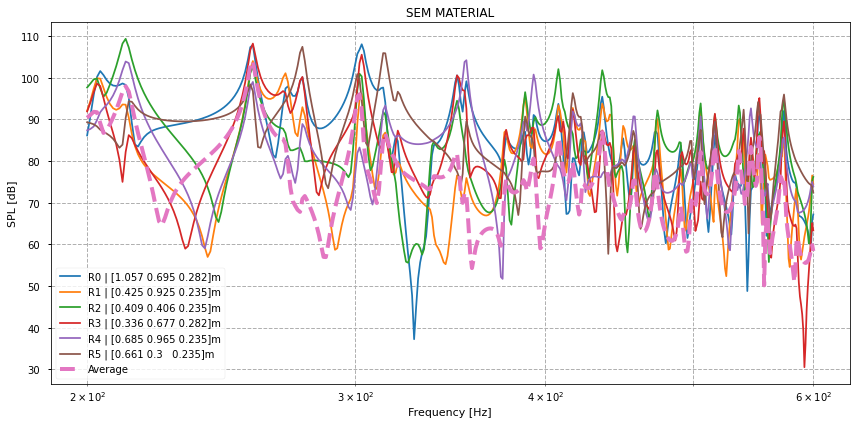

In [25]:
# Plote dos NPS resultantes em cada receptor
plt.style.use('seaborn-notebook')
plt.figure(figsize=(12,6))

if len(obj.R.coord)==1:
  plt.semilogx(obj.freq, p2SPL(obj.pR), linestyle='-', label=f'R | {obj.R.coord[0]}m')
else:
  for i in range(len(obj.R.coord)):
      plt.semilogx(obj.freq, p2SPL(obj.pR[:,i]), linestyle='-', label=f'R{i} | {obj.R.coord[i,:]}m')

if len(obj.R.coord) > 1:
  pR_med = np.mean(obj.pR,axis=1)
  plt.semilogx(obj.freq, p2SPL(pR_med), linestyle='--', label='Average', linewidth=4)
plt.title('SEM MATERIAL')
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
#plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
#plt.ylim(40,160)
plt.tight_layout()
plt.show()

### Comparação NPS dos pontos medido e simulado

In [45]:
with open("G:\Meu Drive\TCC\Simulacao_computacional\codes\dados-pickle\cena1\Zs_0_004_obj_Minicamara1_150_2000_0_5.pkl","rb") as arquivo:
  obj1 = pickle.load(arquivo)

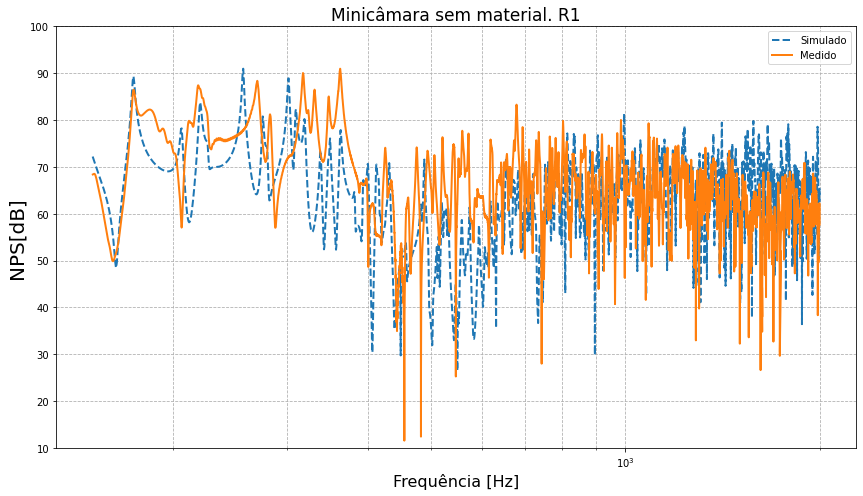

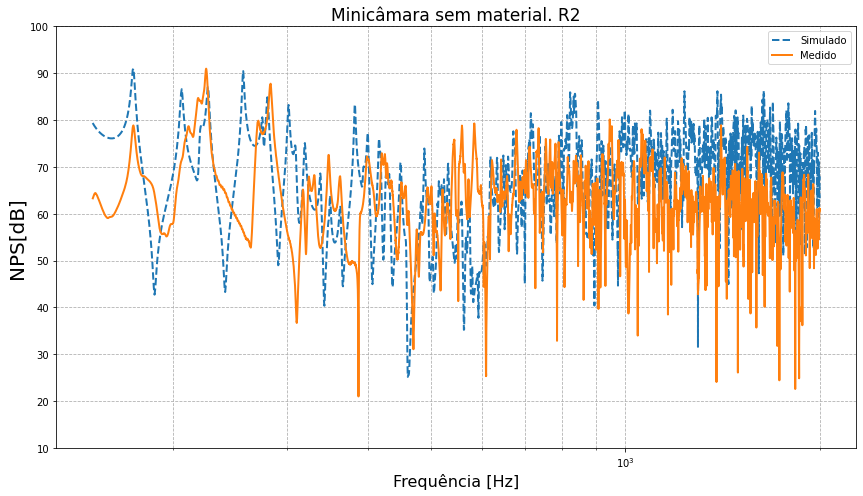

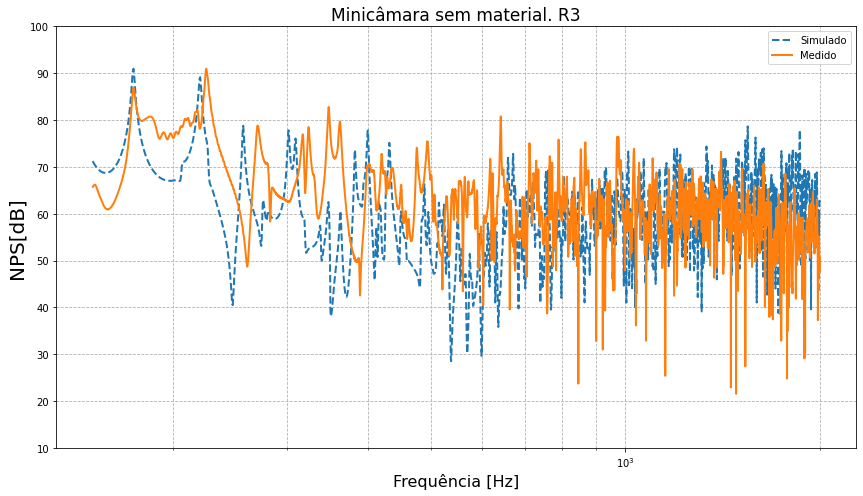

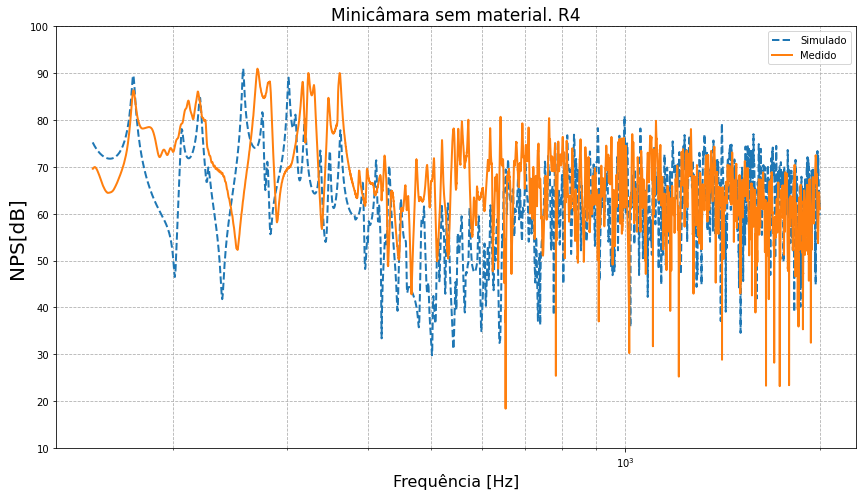

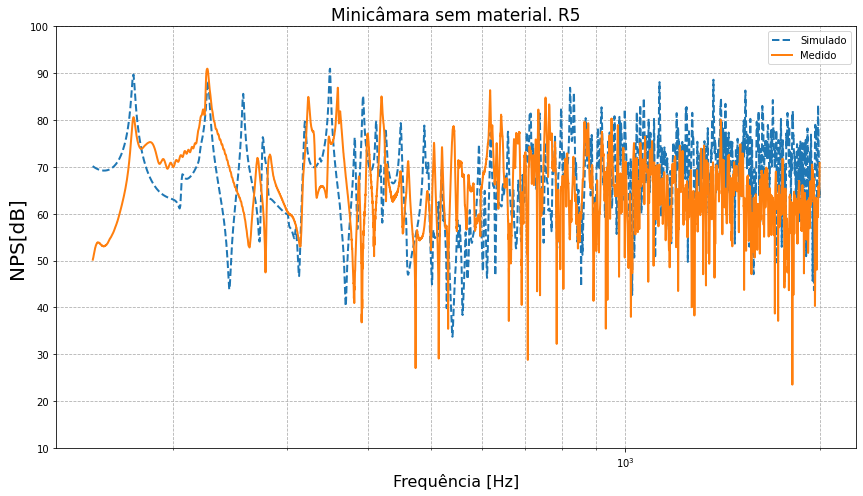

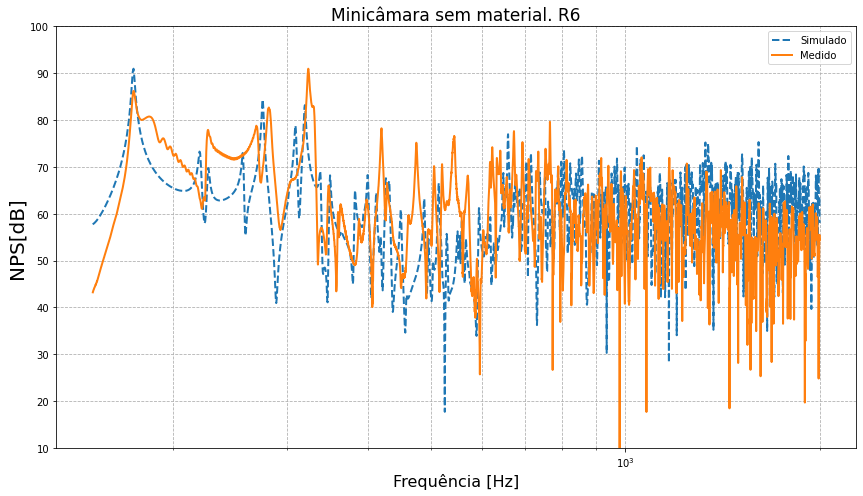

In [181]:
for n in range(0,6): # Admitancia = 0.004
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_semMat['R_semMatfreq'][1981:26401,n]/max(abs(R_semMat['R_semMatfreq'][1981:26401,n]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show() 

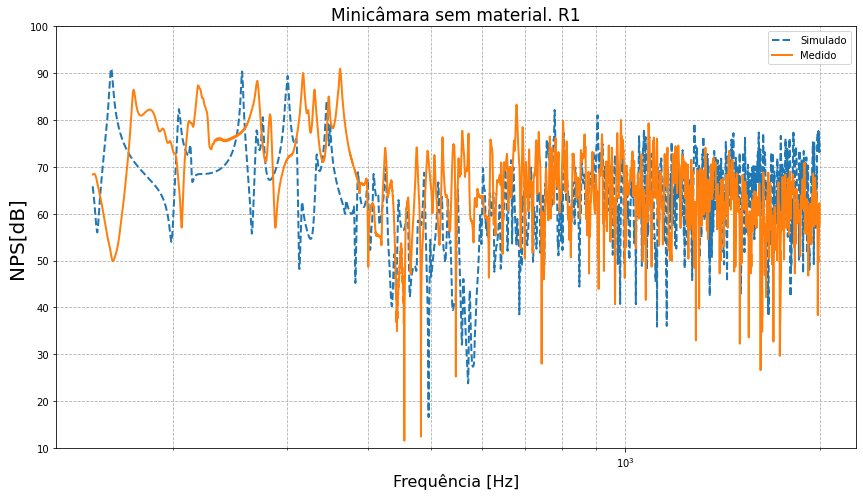

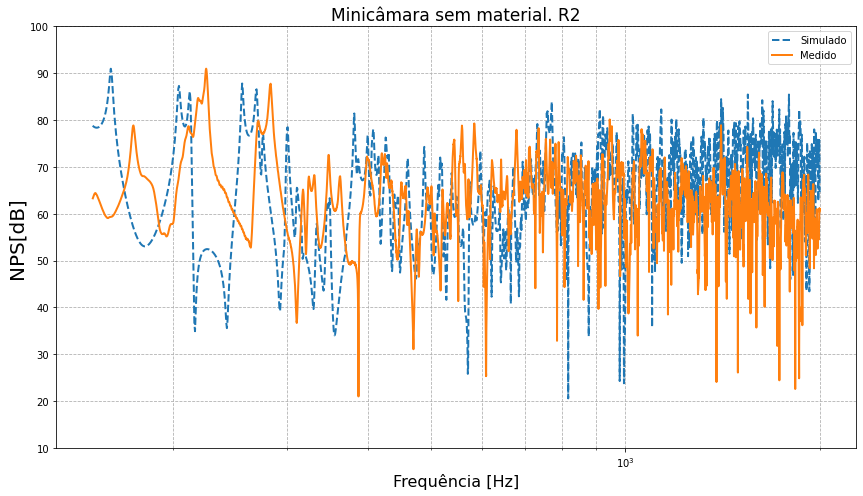

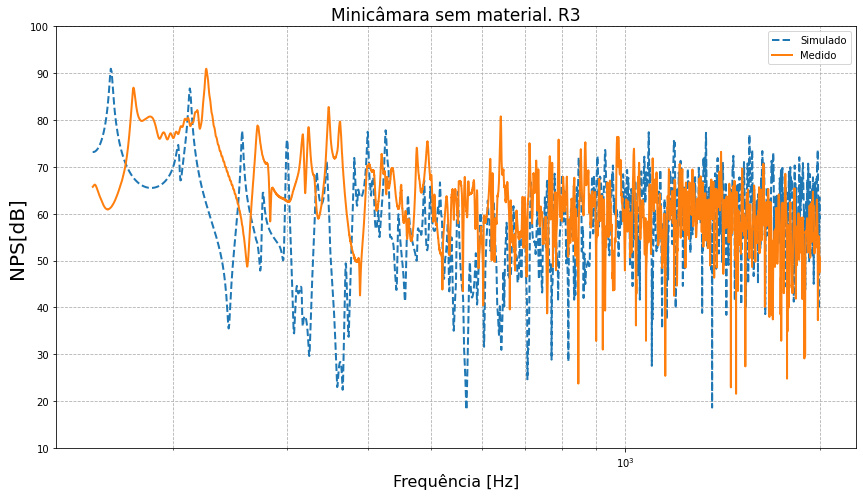

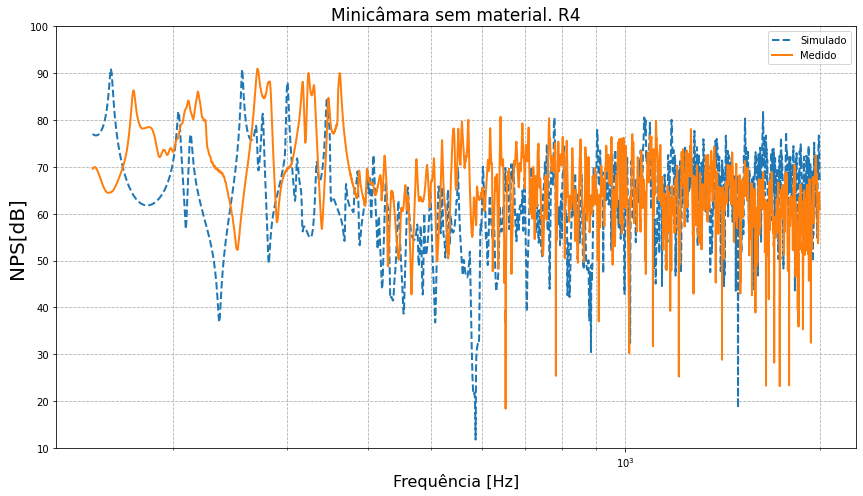

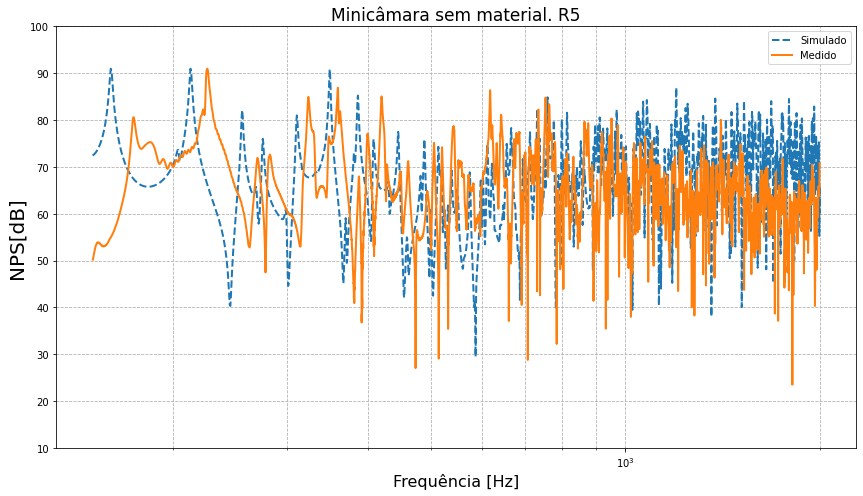

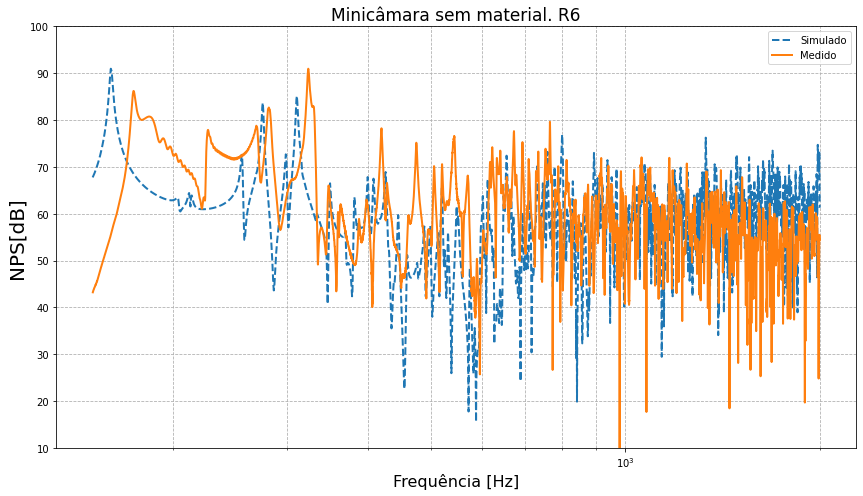

In [151]:
fmax = 2000
fmin = 150
#AC = fd.AlgControls(AP,fmin,fmax,0.5)
AC = fd.AlgControls(AP,fmin,fmax,0.5)
for n in range(0,6):
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj1[:,n]/max(abs(obj1[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_semMat['R_semMatfreq'][1981:26401,n]/max(abs(R_semMat['R_semMatfreq'][1981:26401,n]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
    #plt.xlim((150,500))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show() 

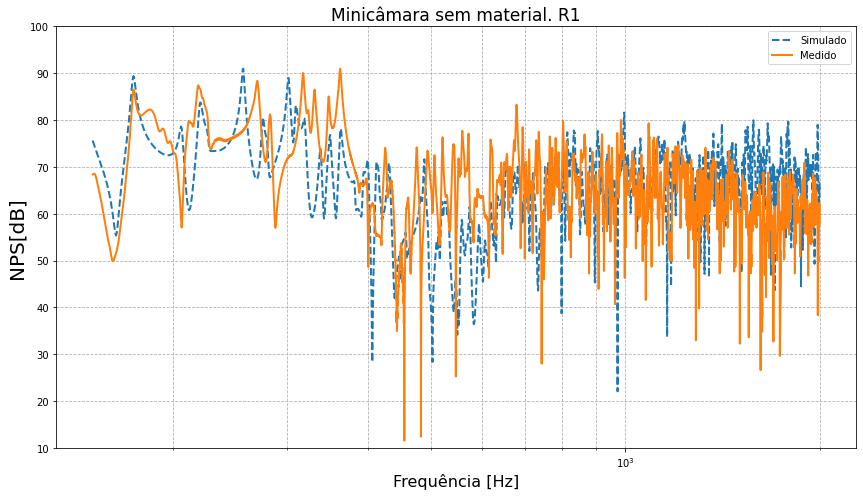

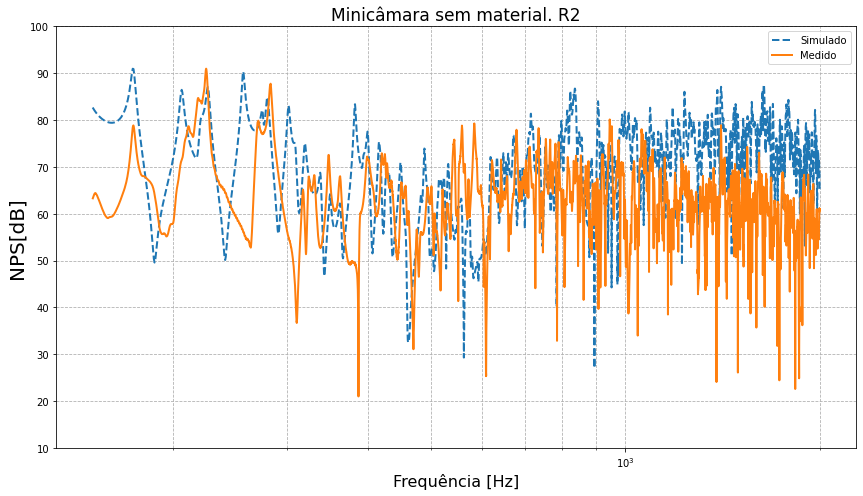

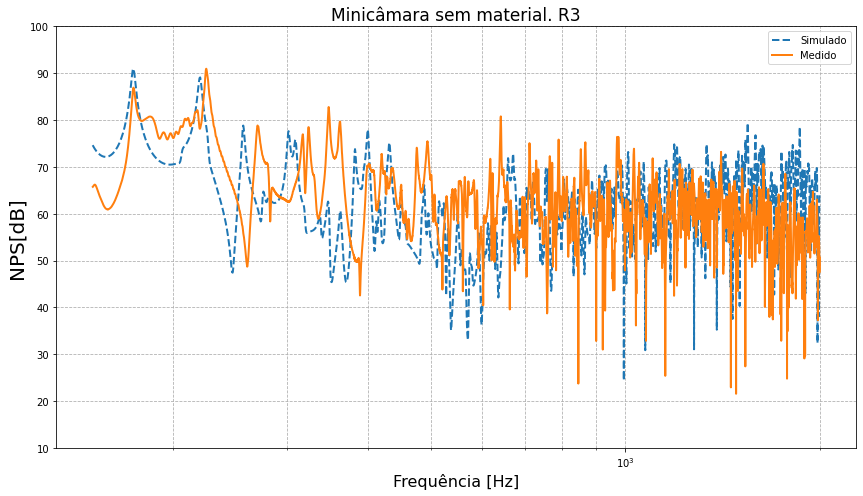

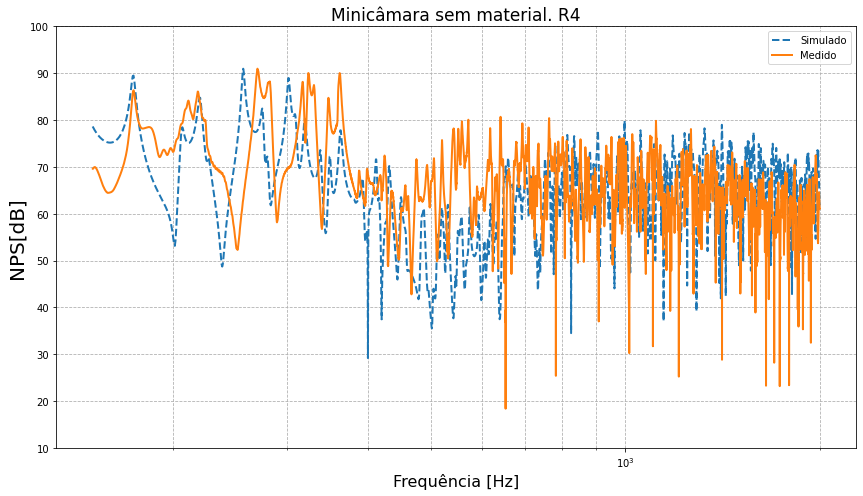

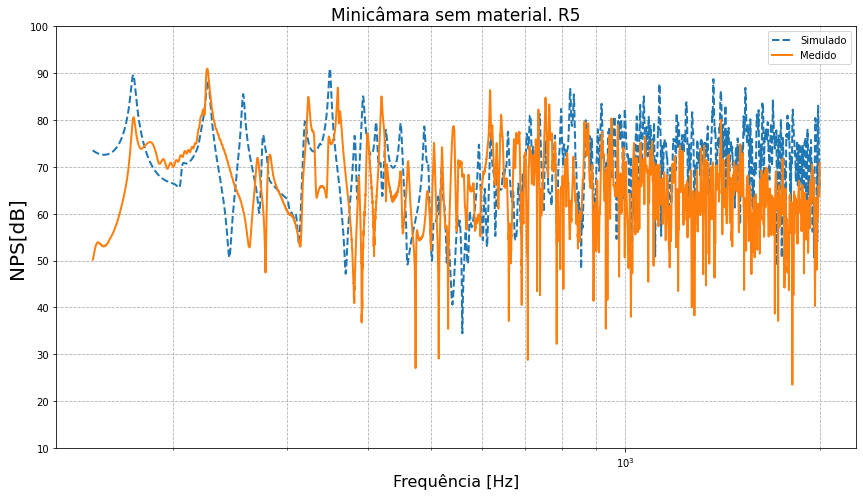

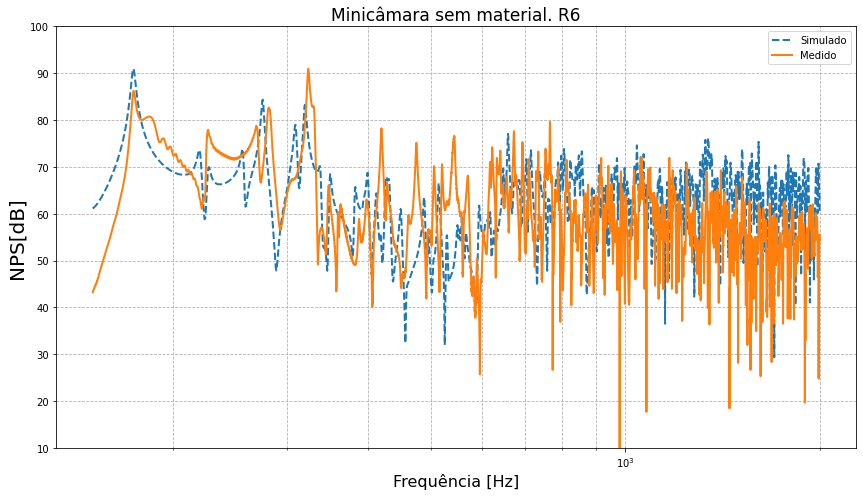

In [152]:
for n in range(0,6):  # Admitancia = 0.006
    plt.figure(figsize=(12,7))
    plt.semilogx(AC.freq, p2SPL(obj.pR[:,n]/max(abs(obj.pR[:,n]))),label='Simulado', linestyle='--', linewidth=2)
    plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_semMat['R_semMatfreq'][1981:26401,n]/max(abs(R_semMat['R_semMatfreq'][1981:26401,n]))), linestyle='-', label = 'Medido',linewidth=2)
    plt.grid(linestyle = '--', which='both')
    plt.legend(loc='best')
    plt.title(f'Minicâmara sem material. R{n+1}', fontsize=17)
    plt.xlabel('Frequência [Hz]', fontsize=16)
    plt.ylabel(r'NPS[dB]', fontsize=20)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([200,250,315,400,500,630,800,1000,1250,1600,2000],[200,250,315,400,500,630,800,1000,1250,1600,2000])
    plt.tight_layout()
    plt.ylim((10,100))
# plt.xlim((200,2000))
#plt.savefig("/content/drive/MyDrive/TCC/Documento/abs_teto.pdf")
    plt.show() 

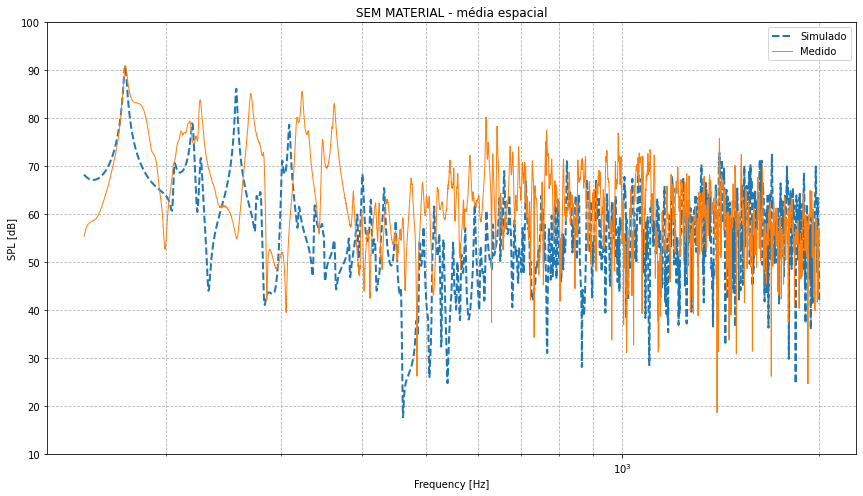

In [184]:

pR_med = np.mean(obj.pR,axis=1) # R_semMat['R_semMatfreq'][2641:7921,n]
R_med = np.mean(R_semMat['R_semMatfreq'][1981:26401],axis=1)
plt.figure(figsize=(12,7))
plt.title('SEM MATERIAL - média espacial')
plt.semilogx(obj.freq, p2SPL(pR_med/max(abs(pR_med))), linestyle='--', label='Simulado', linewidth=2)
plt.semilogx(R_semMat['freqVector'][1981:26401,0], p2SPL(R_med/max(abs(R_med))), linestyle='-', label='Medido', linewidth=1)
plt.grid(linestyle = '--', which='both')
plt.legend(loc='best')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL [dB]')
# plt.ylim(40,160)
#plt.xticks([20,40,60,80,100,120,160,200],[20,40,60,80,100,120,160,200]);
#plt.xticks([100,125,160,200,250,315,400,500,630,1000,1250],[100,125,160,200,250,315,400,500,630,1000,1250]);
plt.tight_layout()
plt.ylim((10,100))
plt.show()

### Comparação RIs dos pontos medido e simulado

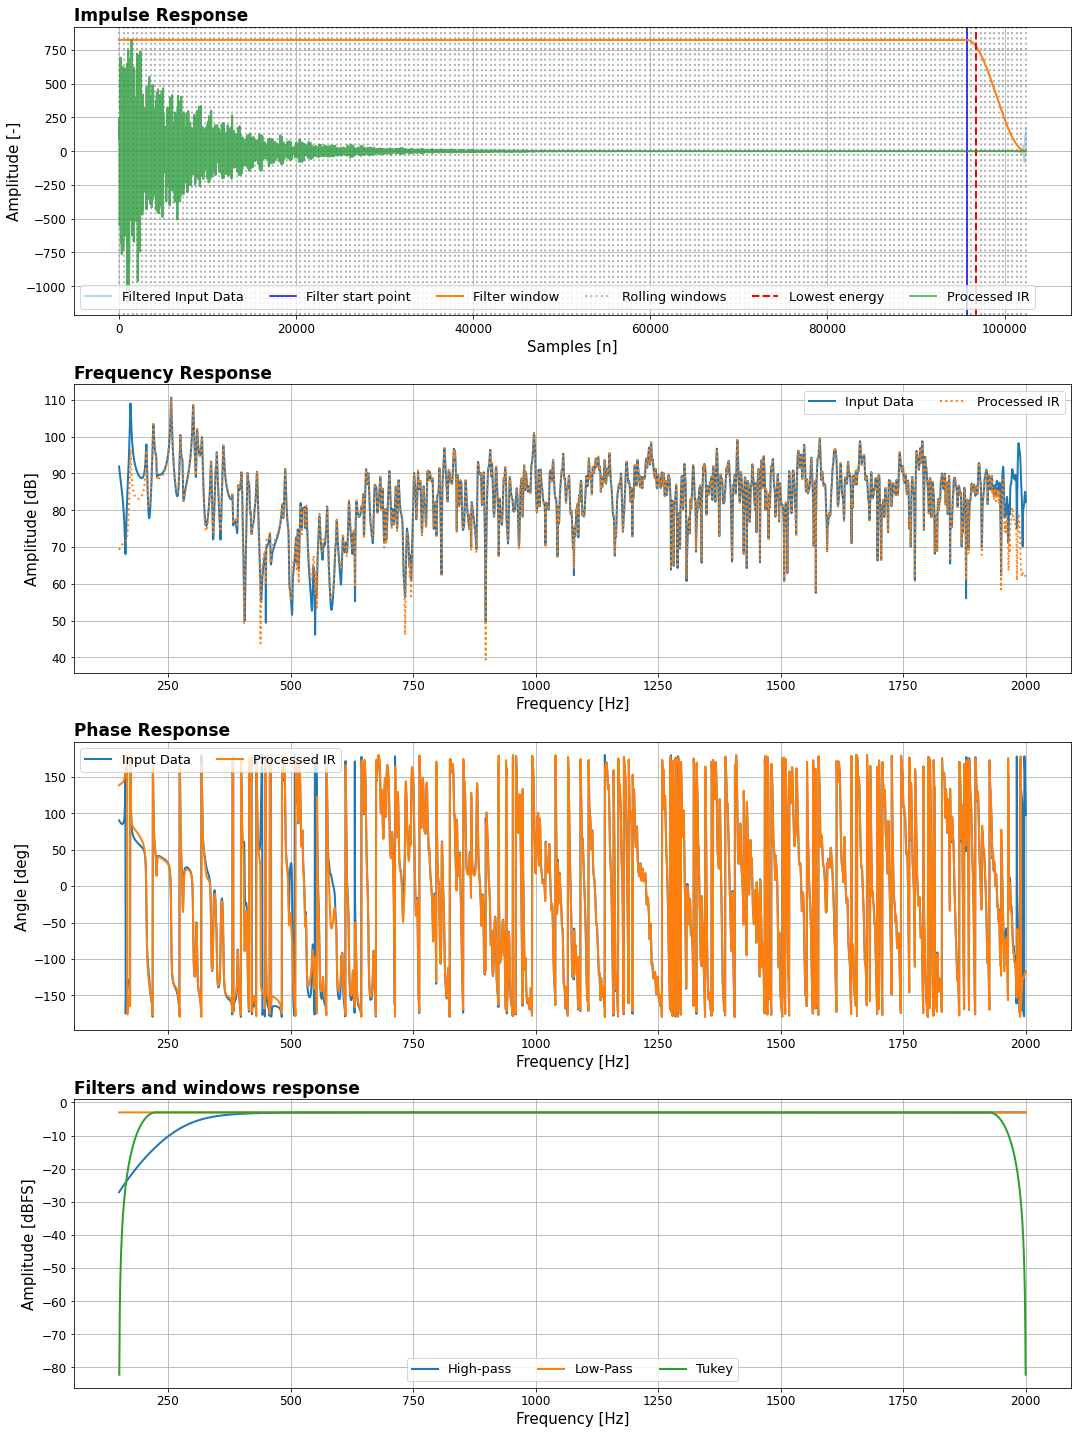

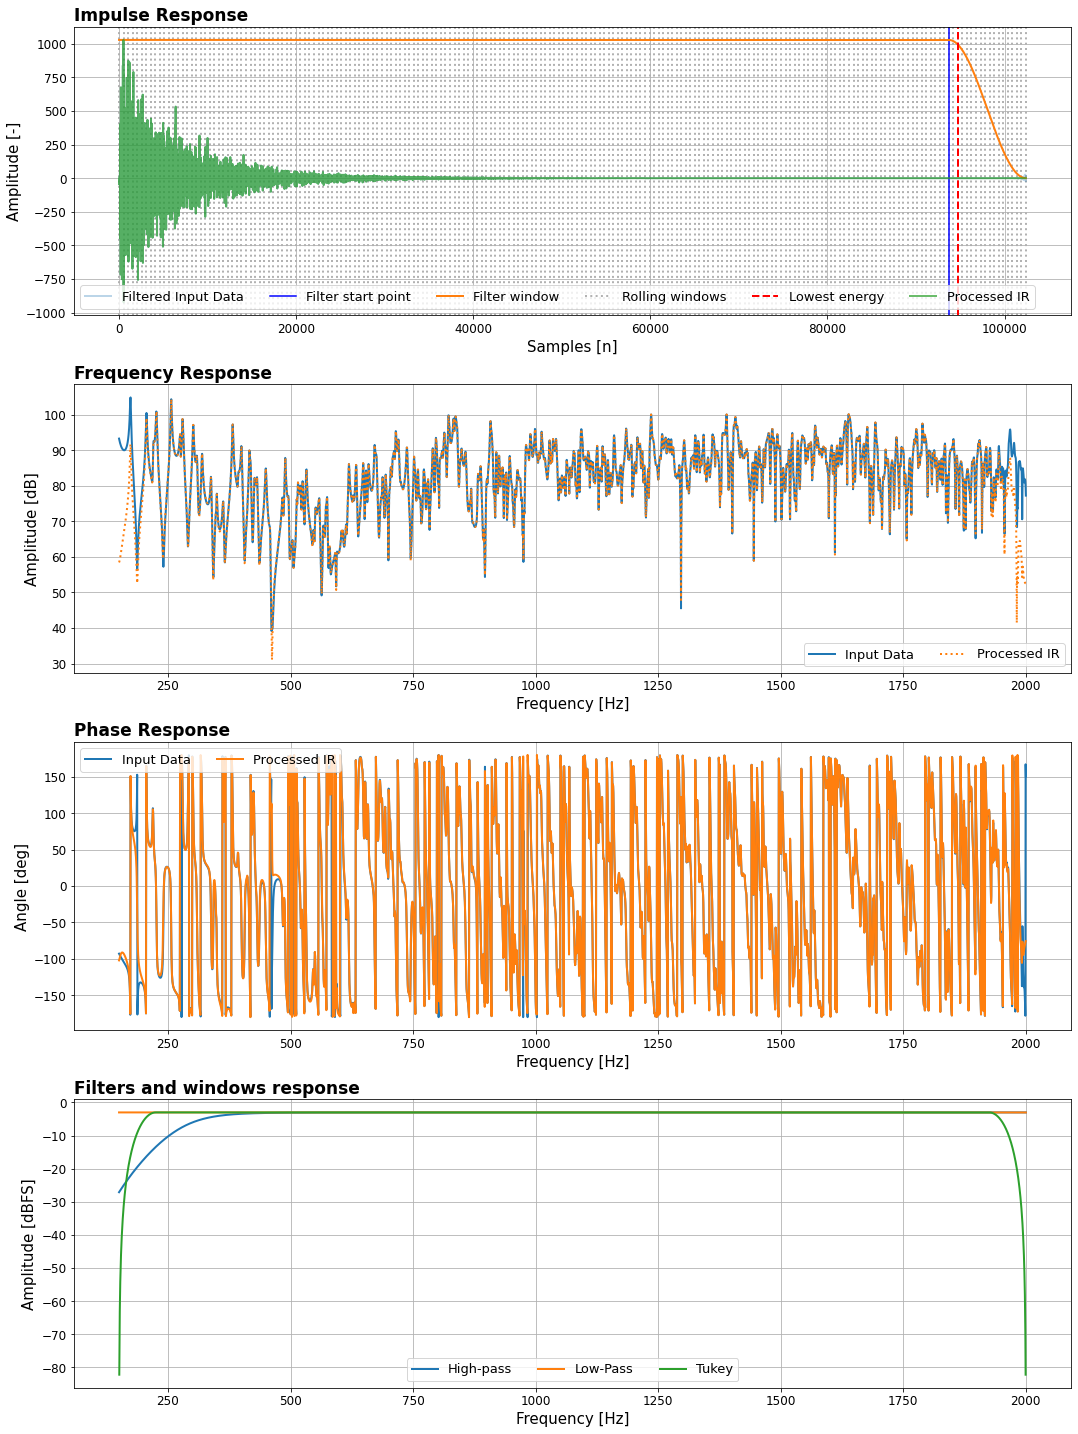

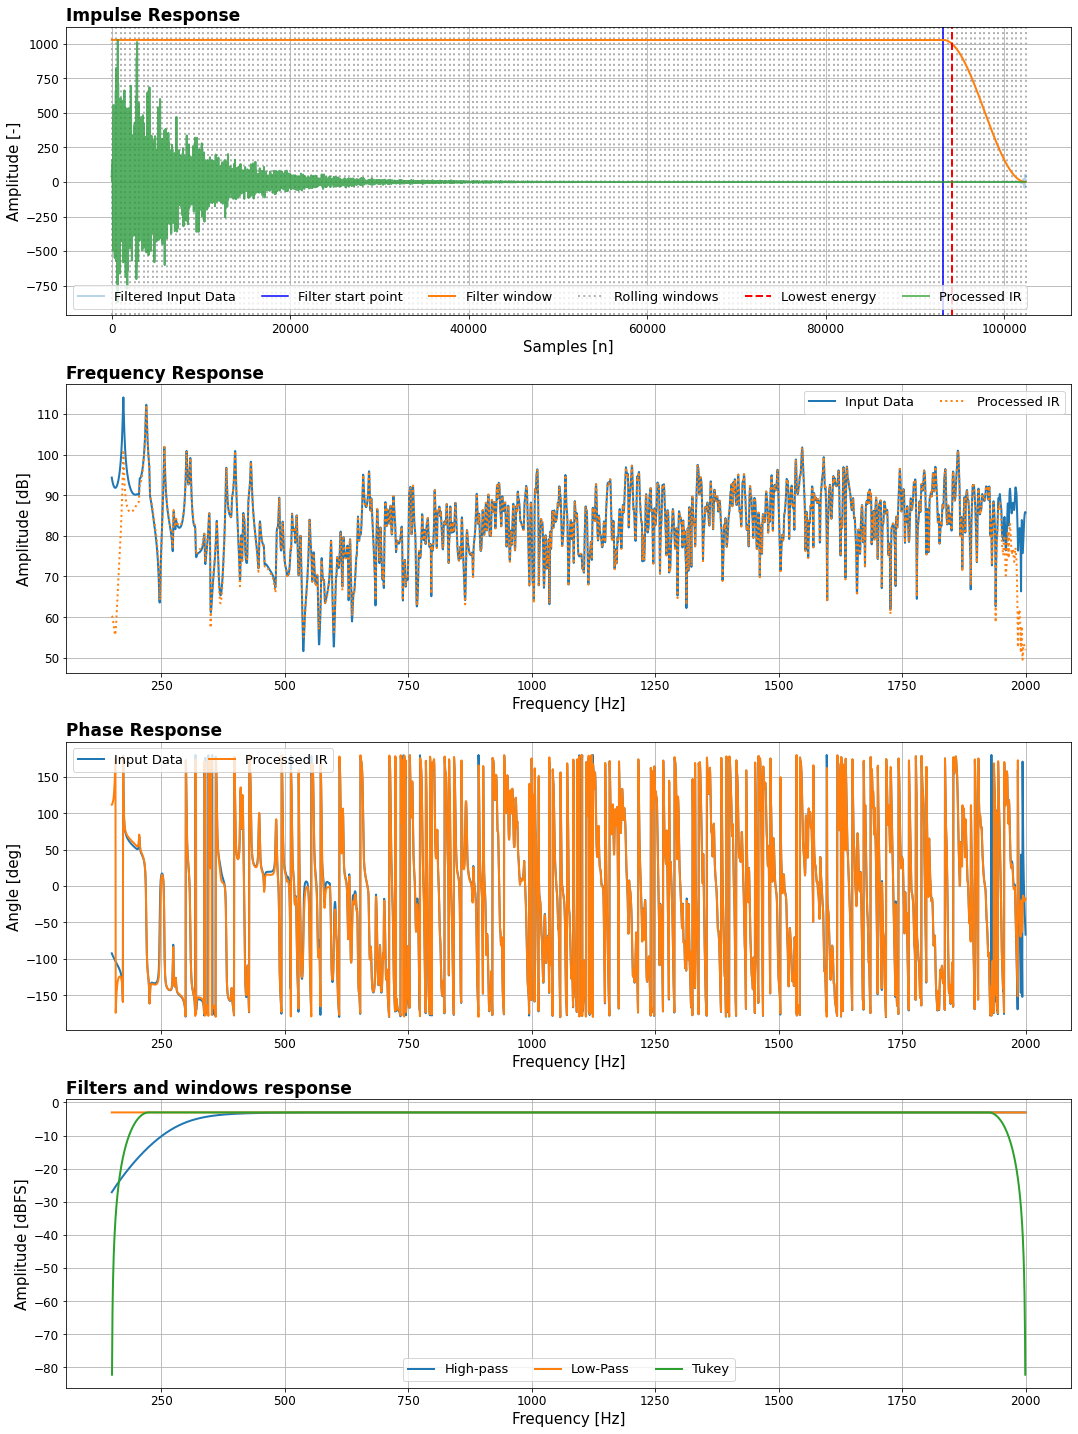

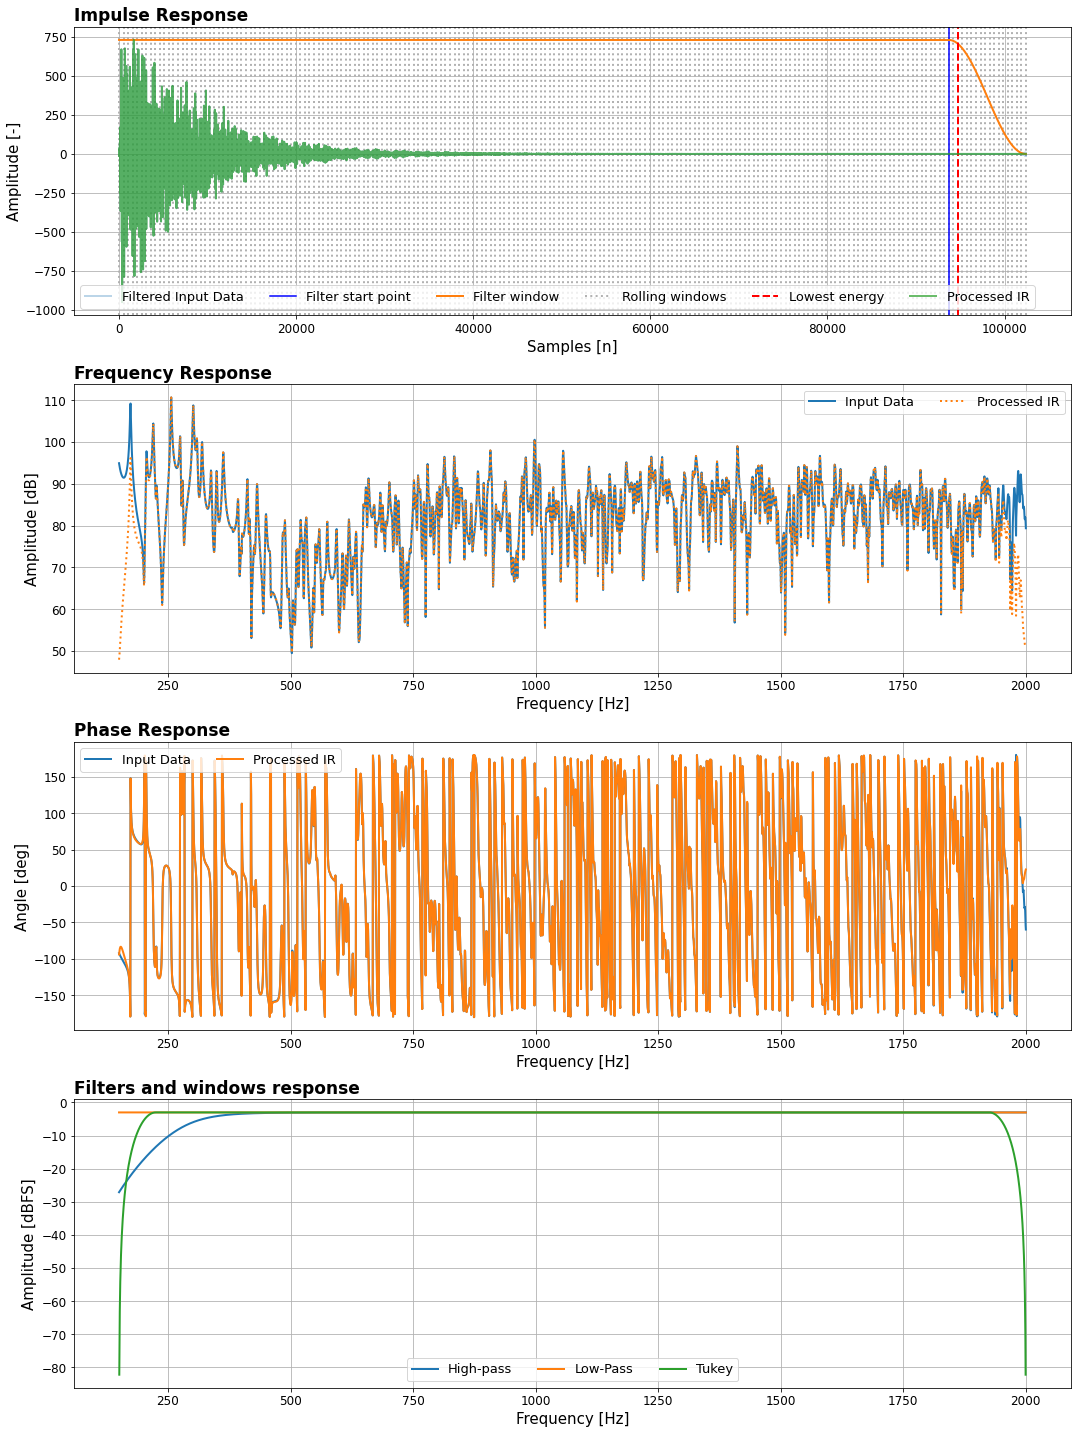

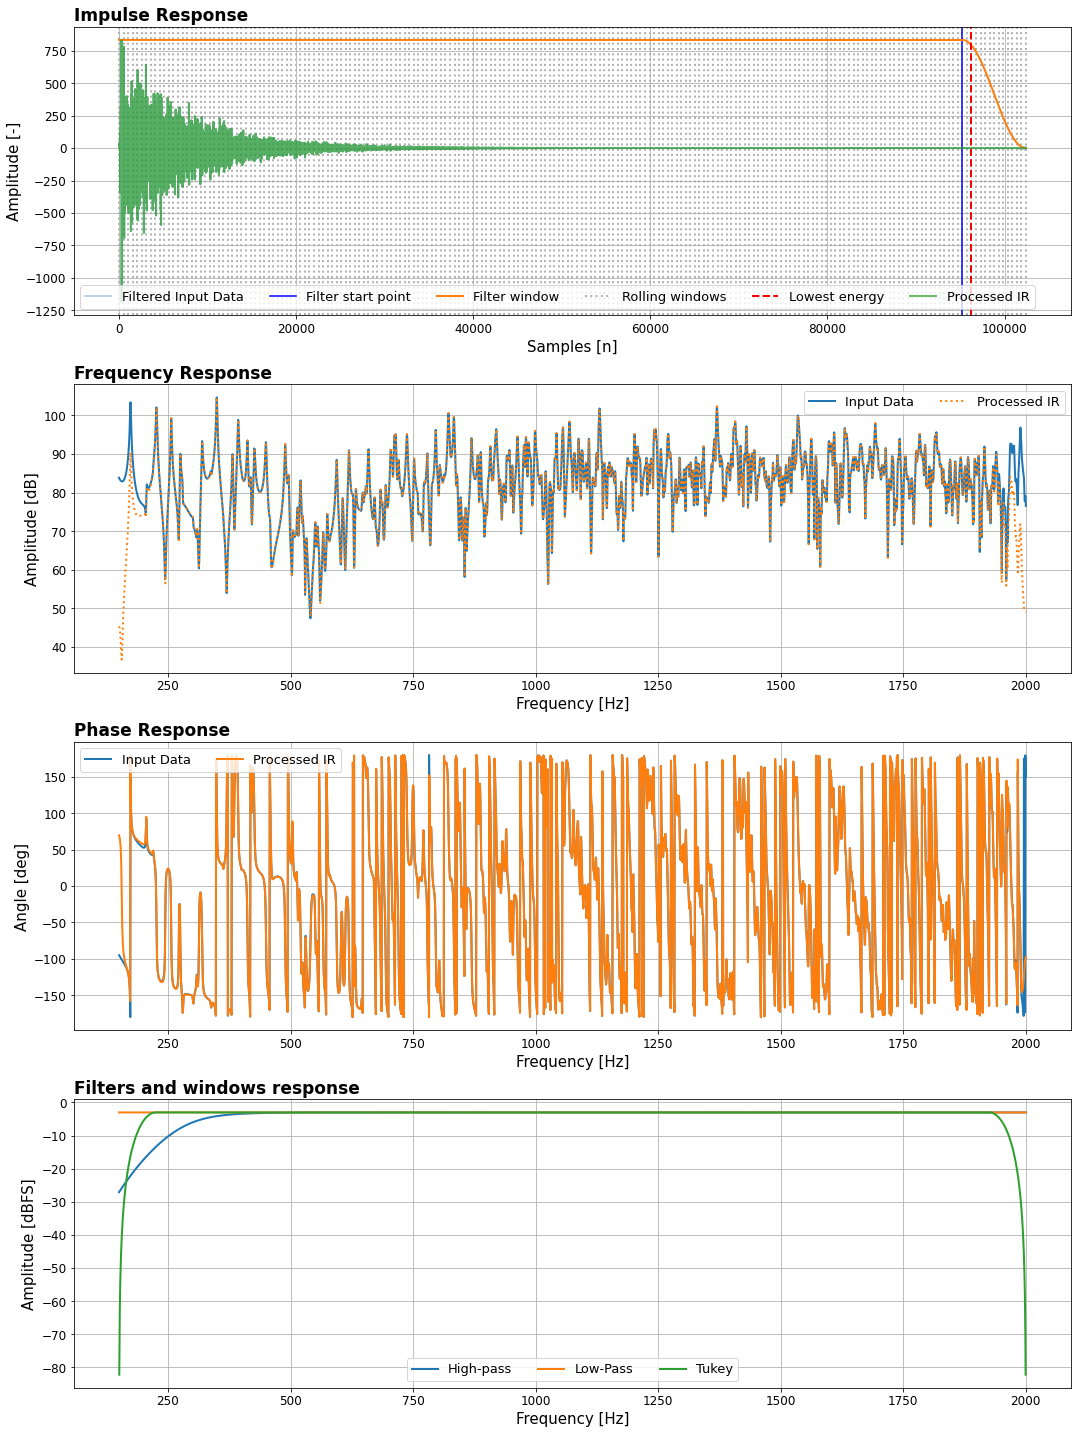

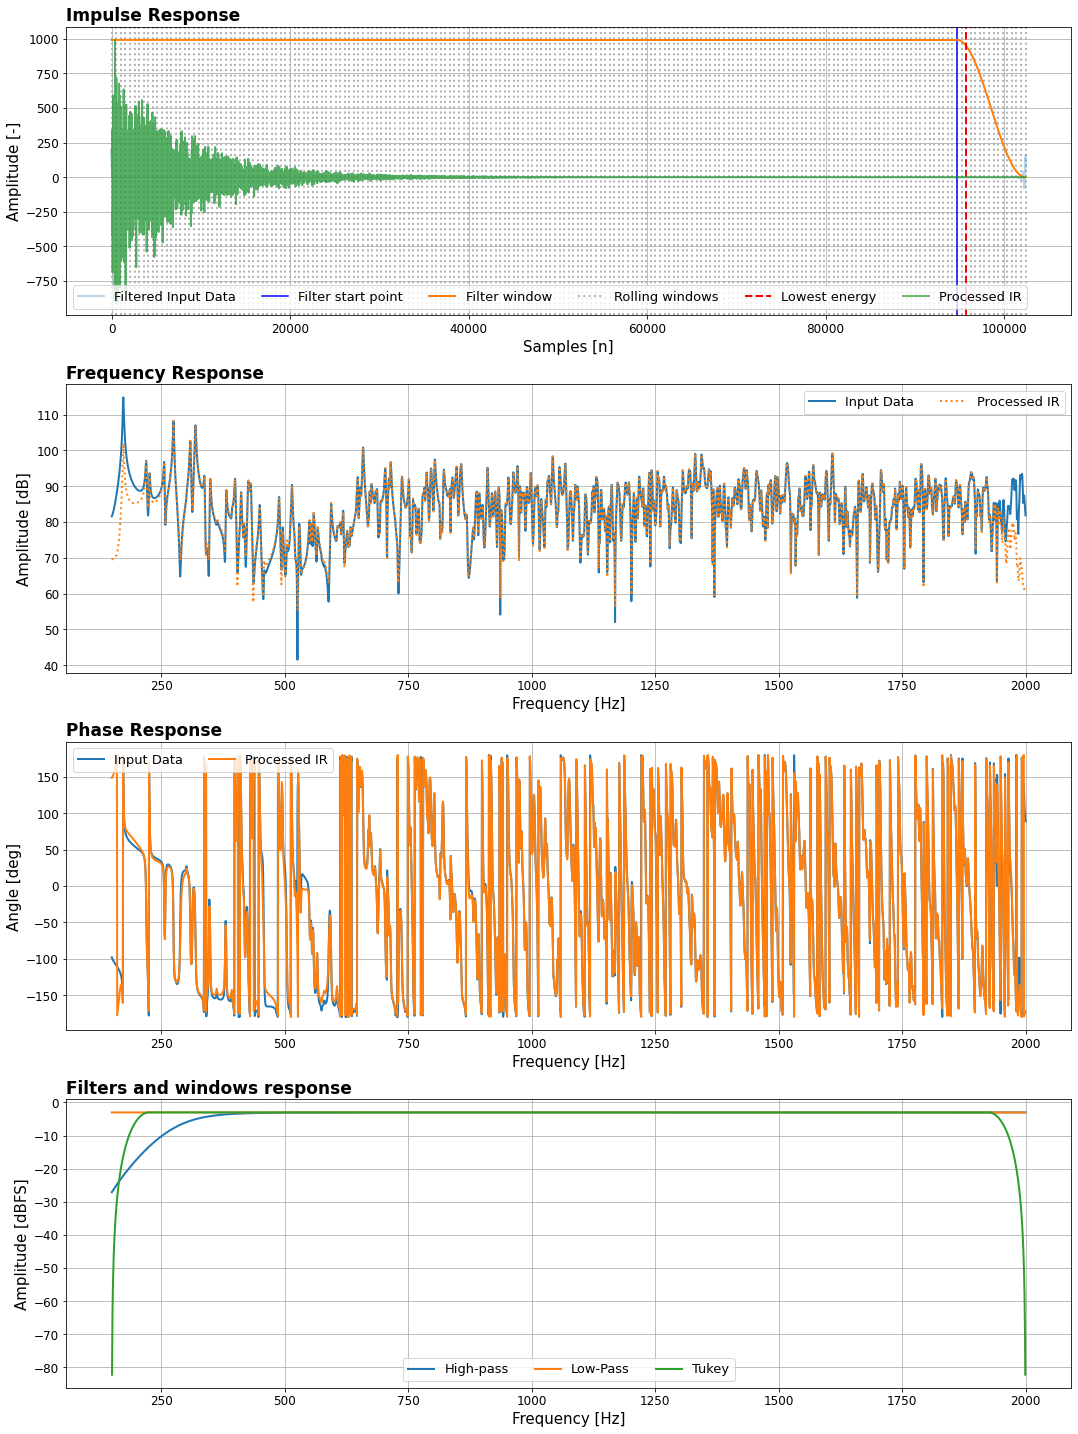

In [182]:
#%% Resposta Impulsiva
domain = fd.Domain(fmin, fmax,2,51200)
domain.alpha = 0.1
ir = np.zeros((len(RI_semMat['RIs_sz']),len(obj.pR[0,:])))
for n in range(0,len(obj.pR[0,:])):
    ir[:,n] = domain.compute_impulse_response(obj.pR[:,n], view=True, irr_filters=False)


In [183]:
# Salvar os dados p importar no MATLAB
from scipy.io import savemat
savemat('G:\Meu Drive\TCC\Simulacao_computacional\minicamara-90mm\Zs_cte0_004_RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})


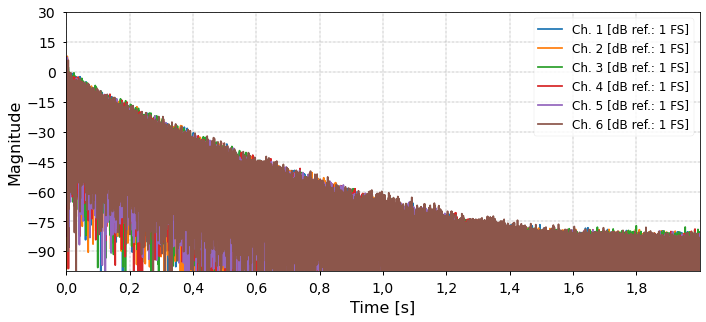

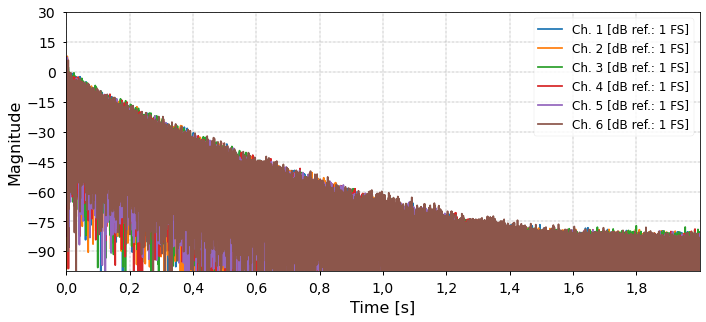

In [84]:

import pytta
txAmostragem = 51200 # [Hz]
# fftDegree = 19
# T = (2**fftDegree-1)/txAmostragem # [s]
# Cria vetor no tempo de um sinal aleatório
#meuRuido = np.random.randn(txAmostragem*T)
# SignalObj com sinal provido pelo usuário
RI_semMat = pytta.SignalObj(RI_semMat['RIs_sz'], 'time', txAmostragem) 
RI_semMat.plot_time_dB(yLim=[-100,30])

### Plote do campo de pressão

In [63]:
# Plote do campo de pressão
obj.pressure_field(frequencies = 300,renderer='browser',axis=['xy','yz'],saveFig=False,camera_angles=['diagonal_front'],extension='pdf')

G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\mini-camarareverb.iges


100%|██████████| 203/203 [00:00<00:00, 2788.65it/s]



	Elapsed time to evaluate acoustic field: 0.09 minutes

